In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,recall_score, precision_score, f1_score, roc_curve, auc)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization, Embedding, Flatten, Input, Concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


                                  Rekonstruovaný text  label
0   Palestinians switch off Christmas lights in Be...      1
1   China says Trump call with Taiwan president wo...      1
3   Zimbabwe military chief's China trip was norma...      1
5   Suspected Boko Haram suicide bombers kill at l...      1
7   Senate Democrats ask Trump attorney general pi...      1
10  A North Korea nuclear test over the Pacific? L...      1
11  Czech police ask parliament to allow prosecuti...      1
14  Nearly half of Americans still oppose Republic...      1
15  White House declines to say if Trump has made ...      1
16  U.S. appeals court hears arguments on Virginia...      1
20  Argentina says satellite calls detected, likel...      1
21  Trump gains ground on Clinton: Reuters/Ipsos S...      1
22  Carson to HUD: The agency that oversees public...      1
30  McConnell says will discuss Supreme Court pick...      1
31  U.S. plan to move Israel embassy sign of 'fail...      1
32  lol listen to yoko o

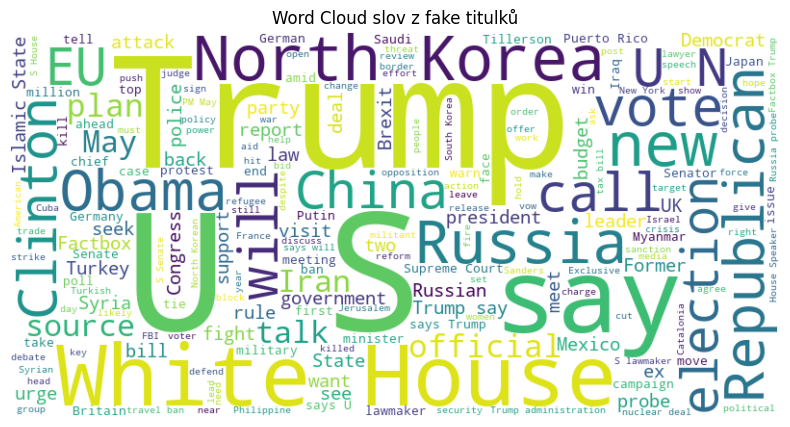

In [3]:
# Načtení původního datasetu
df = pd.read_csv("train (2).csv", sep=";")  # Uprav cestu k souboru podle potřeby

# Použití původních titulků místo predikovaných dat
df["Rekonstruovaný text"] = df["title"].astype(str)

# Zobrazení několika ukázkových fake textů (filtrujeme jen fake news)
df_fake = df[df["label"] == 1]  # Předpokládám, že 1 označuje fake news
print(df_fake[["Rekonstruovaný text", "label"]].head(20))

# Vytvoření Word Cloud pro fake titulky
fake_texts = " ".join(df_fake["Rekonstruovaný text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(fake_texts)

# Zobrazení Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud slov z fake titulků")
plt.show()

                                  Rekonstruovaný text  label
2    FAIL! The Trump Organization’s Credit Score W...      0
4   THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...      0
6   WATCH: John Oliver Presents GOP Debates As ‘Cl...      0
8    Trump HUMILIATES Republicans In Latest Hissy ...      0
9   MACY’S GETS THE BOOT FROM LOYAL CUSTOMERS AFTE...      0
12  ONE DEMOCRAT WHO REFUSES To Cast Electoral Vot...      0
13   WATCH: Senator Al Franken Just Ripped Ted Cru...      0
17  WOW! UNHINGED CLOWN DEMOCRAT Goes Nuts On Hous...      0
18   Heiress To Disney Empire Knows GOP Scammed Us...      0
19   Trump Staffers Admit Their Boss Has No Idea W...      0
23  WATCH: NANCY PELOSI COMES UNGLUED! Calls A Pie...      0
24   WATCH: Donald Trump Is OBSESSED With His Desi...      0
25  BIKERS FOR TRUMP Will Travel To Future Rallies...      0
26  “HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treat...      0
27  [Video] BURGER KING MANAGER CURSES OUT AND THR...      0
28   ‘God Is Gay’: SNL D

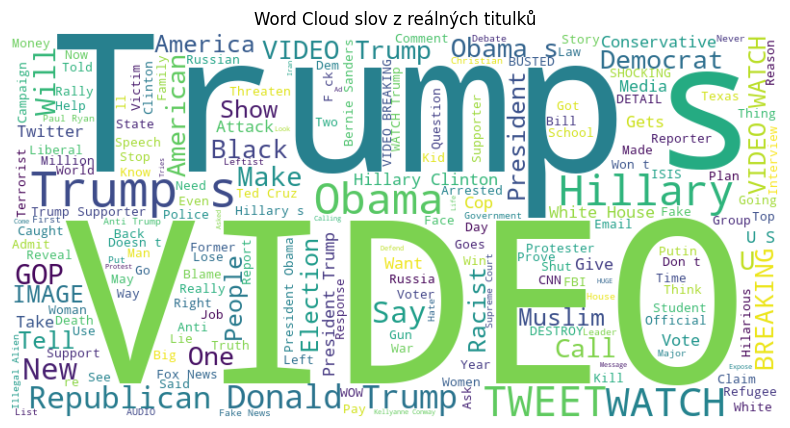

In [4]:
# Načtení původního datasetu
df = pd.read_csv("train (2).csv", sep=";")  # Uprav cestu k souboru podle potřeby

# Použití původních titulků místo predikovaných dat
df["Rekonstruovaný text"] = df["title"].astype(str)

# Filtrujeme jen reálné (pravdivé) titulky
df_real = df[df["label"] == 0]  # Předpokládám, že 0 označuje reálné zprávy
print(df_real[["Rekonstruovaný text", "label"]].head(20))

# Vytvoření Word Cloud pro reálné titulky
real_texts = " ".join(df_real["Rekonstruovaný text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(real_texts)

# Zobrazení Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud slov z reálných titulků")
plt.show()

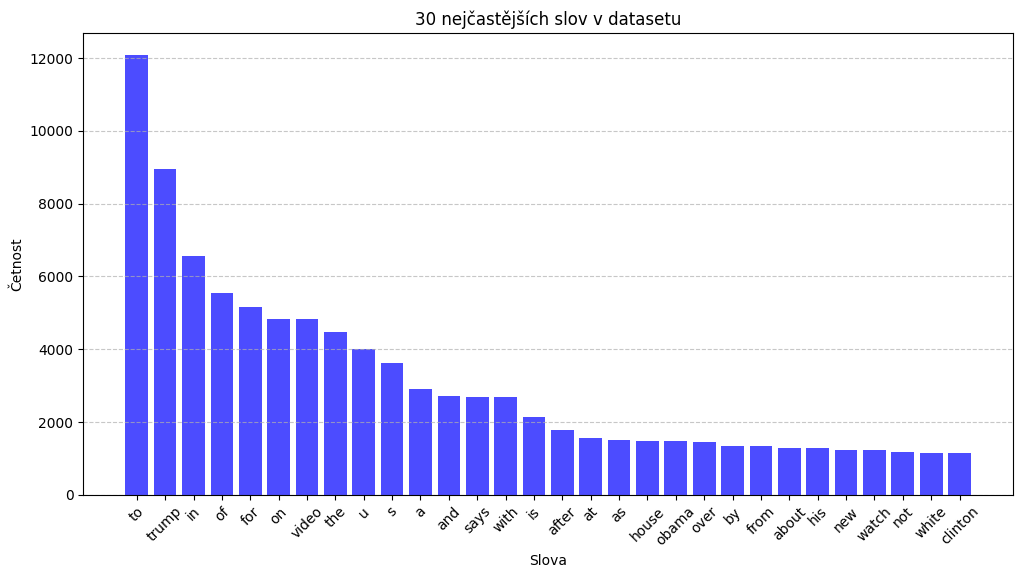

In [5]:
#ssuming your data is in 'train (2).csv' and 'test (1).csv'
train_df = pd.read_csv('train (2).csv', sep=';')
test_df = pd.read_csv('test (1).csv', sep=';')
df_all = pd.concat([train_df, test_df]) # create df_all by concatenating train and test

#Ujistíme se, že 'title' neobsahuje NaN hodnoty
df_all['title'] = df_all['title'].astype(str).fillna("")

#Tokenizace všech textů v datasetu
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_all['title'])

#Počet slov v datasetu
word_counts = dict(tokenizer.word_counts)

#Seřazení slov podle četnosti (sestupně)
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

#Výběr 30 nejčastějších slov
top_words = sorted_word_counts[:30]
words, counts = zip(*top_words)  # Rozdělení na slova a jejich četnosti

#Graf distribuce četnosti slov
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='blue', alpha=0.7)
plt.xlabel("Slova")
plt.ylabel("Četnost")
plt.title("30 nejčastějších slov v datasetu")
plt.xticks(rotation=45)  # Otočení popisků osy X pro lepší čitelnost
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Zobrazení grafu
plt.show()

In [6]:
# Načtení dat
def load_and_merge_data(train_path, test_path, submit_path):
    train_df = pd.read_csv(train_path, sep=';')
    test_df = pd.read_csv(test_path, sep=';')
    submit_df = pd.read_csv(submit_path, sep=';')
    test_df = pd.concat([test_df, submit_df], axis=0, ignore_index=True).drop(columns=["idS"], errors='ignore')
    df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    return df_all

# Funkce pro předzpracování dat
def preprocess_data(df, vocab_size=5000, max_length=100):
    target_column = df.columns[-1]
    X = df.drop(columns=[target_column])
    Y = df[target_column]

    # Imputace chybějících numerických hodnot
    imputer = SimpleImputer(strategy='mean')
    X_num_imputed = pd.DataFrame(imputer.fit_transform(X.select_dtypes(include=np.number)), columns=X.select_dtypes(include=np.number).columns)

    # Transformace textových dat pomocí embedding vrstvy
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")  # Použijeme max 5000 slov
    if 'title' in df.columns:
        titles = df['title'].astype(str).fillna("")
        tokenizer.fit_on_texts(titles)
        X_title_seq = tokenizer.texts_to_sequences(titles)  # Převedeme text na číselné indexy
        X_title_padded = pad_sequences(X_title_seq, maxlen=max_length, padding='post')  # Zkrátíme/rozšíříme délku na max_length
    else:
        X_title_padded = np.zeros((X.shape[0], max_length))  # Pokud title není, nastavíme nuly

    # Standardizace numerických dat
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num_imputed)


    # Label encoding a one-hot encoding pro cílovou proměnnou
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_onehot = one_hot_encoder.fit_transform(Y_encoded.reshape(-1, 1))

    return X_num_scaled, X_title_padded, Y_onehot, vocab_size, max_length # Return 5 items as line 43 expects

# Funkce pro vytvoření modelu
def create_model(input_shape, vocab_size, max_length, num_classes, embedding_dim=25): # Snížení embedding_dim
    input_num = Input(shape=(input_shape,))
    input_text = Input(shape=(max_length,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_text)
    flatten_layer = Flatten()(embedding_layer)
    merged = Concatenate()([input_num, flatten_layer])

    dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged) # Snížení neuronů a zvýšení L2
    dense = BatchNormalization()(dense) # Přidání BatchNormalization
    dense = Dropout(0.5)(dense) # Zvýšení Dropout rate

    dense = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense)
    dense = BatchNormalization()(dense) # Přidání BatchNormalization
    dense = Dropout(0.5)(dense) # Zvýšení Dropout rate

    dense = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense)
    dense = BatchNormalization()(dense) # Přidání BatchNormalization

    output = Dense(num_classes, activation='softmax')(dense)

    model = Model(inputs=[input_num, input_text], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy']) # Snížení learning rate

    return model

# Načtení a předzpracování dat
df_all = load_and_merge_data('train (2).csv', 'test (1).csv', 'evaluation.csv')
X_num, X_text, Y, vocab_size, max_length = preprocess_data(df_all)

X_train_num, X_test_num, X_train_text, X_test_text, y_train, y_test = train_test_split(X_num, X_text, Y, test_size=0.2, random_state=42)


# Vytvoření a trénování modelu
model = create_model(X_train_num.shape[1], vocab_size, max_length, y_train.shape[1])

model.summary()

early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, mode='max') # Úprava patience
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6, mode='max') # Úprava patience

history = model.fit([X_train_num, X_train_text], y_train,
                    epochs=10, batch_size=64, # Snížení epochs a batch_size
                    validation_data=([X_test_num, X_test_text], y_test),
                    callbacks=[early_stopping, reduce_lr])

d:\DataScience2024\Projekty\Final_project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 25)   │    125,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2500)      │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2501)      │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    160,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │         34 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 288,218 (1.10 MB)

 Trainable params: 287,994 (1.10 MB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6009 - loss: 0.9950 - val_accuracy: 0.7278 - val_loss: 0.6963 - learning_rate: 1.0000e-04
Epoch 2/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7586 - loss: 0.6889 - val_accuracy: 0.8461 - val_loss: 0.5191 - learning_rate: 1.0000e-04
Epoch 3/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8329 - loss: 0.5473 - val_accuracy: 0.8966 - val_loss: 0.4124 - learning_rate: 1.0000e-04
Epoch 4/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8882 - loss: 0.4269 - val_accuracy: 0.9286 - val_loss: 0.3338 - learning_rate: 1.0000e-04
Epoch 5/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9165 - loss: 0.3602 - val_accuracy: 0.9374 - val_loss: 0.3036 - learning_rate: 1.0000e-04
Epoch 6/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9310 - loss: 0.3082 - val_accuracy: 0.9389 - val_loss: 0.2721 - learning_rate: 1.0000e-04
Epoch 7/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy

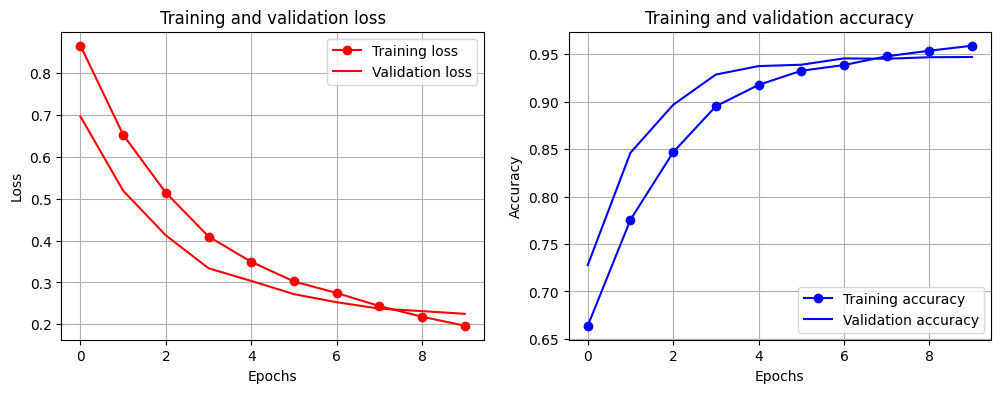

254/254 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3698
           1       0.95      0.95      0.95      4420

    accuracy                           0.95      8118
   macro avg       0.95      0.95      0.95      8118
weighted avg       0.95      0.95      0.95      8118


Confusion Matrix:


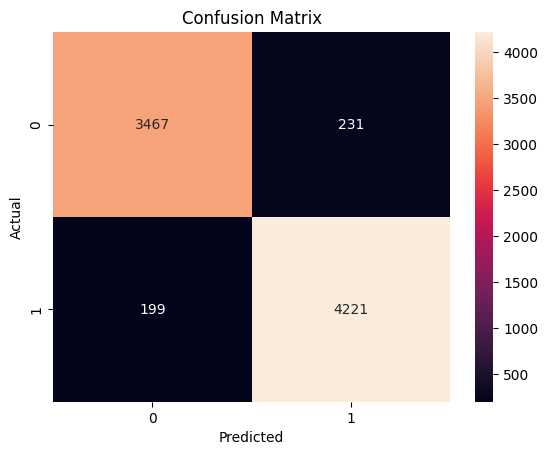

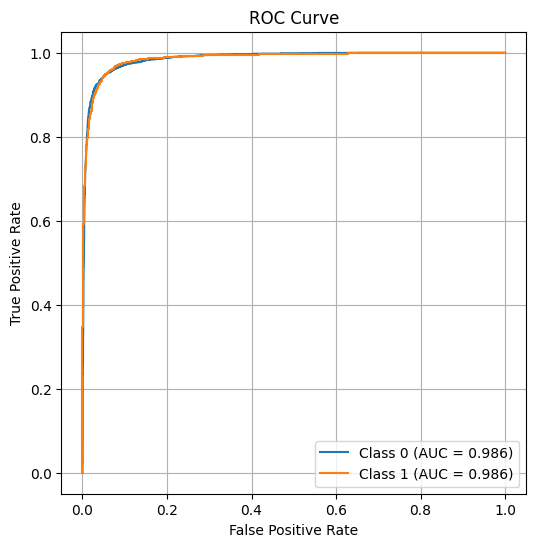

In [11]:
# Vizualizace průběhu trénování
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], "ro-", label="Training loss")
plt.plot(history.history["val_loss"], "r-", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], "bo-", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "b-", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.show()

# Predikce na testovacích datech
y_pred = model.predict([X_test_num, X_test_text])  # Predikce s oběma vstupy
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Klasifikační report a matice záměn
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC křivka a AUC skóre
plt.figure(figsize=(6, 6))
for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [15]:
# Predikce na testovacích datech
y_pred_probs = model.predict([X_test_num, X_test_text])  # Předpovědi s oběma vstupy
y_pred = np.argmax(y_pred_probs, axis=1)  # Převod na nejpravděpodobnější třídu
y_true = np.argmax(y_test, axis=1)  # Skutečné hodnoty

# Výpočet metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Výpis výsledků
print(f'🔹 Přesnost: {accuracy:.4f}')
print(f'🔹 Precision: {precision:.4f}')
print(f'🔹 Recall: {recall:.4f}')
print(f'🔹 F1-score: {f1:.4f}')


254/254 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
🔹 Přesnost: 0.9470
🔹 Precision: 0.9470
🔹 Recall: 0.9470
🔹 F1-score: 0.9470


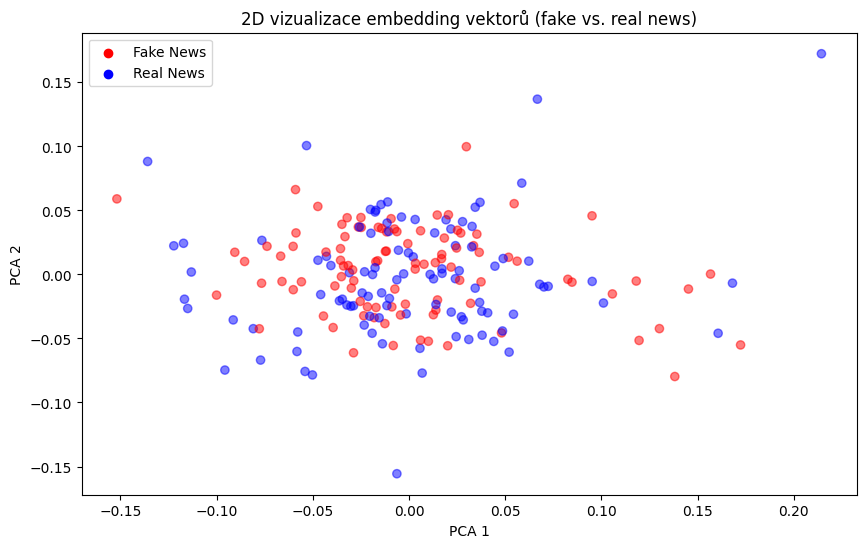

In [16]:
# Získání embedding váh
embedding_layer = model.get_layer("embedding")  # Název vrstvy může být jiný
weights = embedding_layer.get_weights()[0]

# Redukce dimenze na 2D
pca = PCA(n_components=2)
reduced_weights = pca.fit_transform(weights[:200])  # Omezíme na prvních 200 slov

# Získání labelů
labels = df_all['label'][:200]  # Předpokládáme, že prvních 200 labelů odpovídá prvním 200 slovům

# Přiřazení barev
colors = np.array(['red', 'blue'])  # Červená pro fake news, modrá pro real news
colored_labels = colors[labels]

# Vykreslení grafu s barevným kódováním
plt.figure(figsize=(10, 6))
plt.scatter(reduced_weights[:, 0], reduced_weights[:, 1], c=colored_labels, alpha=0.5)
plt.title("2D vizualizace embedding vektorů (fake vs. real news)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# Vytvoření legendy pomocí scatter plotů
legend_elements = [plt.scatter([], [], marker='o', color=colors[0], label='Fake News'),
                   plt.scatter([], [], marker='o', color=colors[1], label='Real News')]
plt.legend(handles=legend_elements)

plt.show()

In [17]:
#Načtení dat
def load_and_merge_data(train_path, test_path, submit_path):
    train_df = pd.read_csv(train_path, sep=';')
    test_df = pd.read_csv(test_path, sep=';')
    submit_df = pd.read_csv(submit_path, sep=';')
    test_df = pd.concat([test_df, submit_df], axis=0, ignore_index=True).drop(columns=["idS"], errors='ignore')
    df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    return df_all

#Funkce pro předzpracování dat
def preprocess_data(df, vocab_size=10000, max_length=150):
    #Cílová proměnná
    Y = df['label']

    # Tokenizace textových sloupců
    tokenizers = {}
    X_text_padded = {}

    for col in ['title', 'text']:  #Zpracujeme oba textové sloupce
        tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
        texts = df[col].astype(str).fillna("")
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)
        X_text_padded[col] = pad_sequences(sequences, maxlen=max_length, padding='post')
        tokenizers[col] = tokenizer  #Uložíme tokenizer pro pozdější použití

    #Label encoding + OneHot encoding pro cílovou proměnnou
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_onehot = one_hot_encoder.fit_transform(Y_encoded.reshape(-1, 1))

    return X_text_padded, Y_onehot, vocab_size, max_length, tokenizers

#Funkce pro vytvoření modelu
def create_model(text_shapes, vocab_size, max_length, num_classes, embedding_dim=50):
    inputs = []
    processed_inputs = []

    #Embedding vrstvy pro textové vstupy
    for text_col, shape in text_shapes.items():
        input_text = Input(shape=(max_length,))
        embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_text)
        flatten_layer = Flatten()(embedding_layer)

        inputs.append(input_text)
        processed_inputs.append(flatten_layer)

    #Spojení všech vstupů
    merged = Concatenate()(processed_inputs)

    #Plně propojené vrstvy
    dense = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.4)(dense)

    dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.4)(dense)

    dense = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense)
    dense = BatchNormalization()(dense)

    output = Dense(num_classes, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Načtení a předzpracování dat
df_all = load_and_merge_data('train (2).csv', 'test (1).csv', 'evaluation.csv')
X_texts, Y, vocab_size, max_length, tokenizers = preprocess_data(df_all)  # Assign output to X_texts

# Rozdělení na trénovací a testovací sadu
df = df_all
X_train_texts = {col: X_texts[col][:int(0.8 * len(df))] for col in X_texts}
X_test_texts = {col: X_texts[col][int(0.8 * len(df)):] for col in X_texts}
y_train = Y[:int(0.8 * len(df))]
y_test = Y[int(0.8 * len(df)):]
#Vytvoření modelu
model = create_model(
    text_shapes={col: max_length for col in X_train_texts},
    vocab_size=vocab_size,
    max_length=max_length,
    num_classes=y_train.shape[1]
)

model.summary()

#Trénování modelu
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6, mode='max')

history = model.fit(
    list(X_train_texts.values()),
    y_train,
    epochs=8, batch_size=128,
    validation_data=(list(X_test_texts.values()), y_test),
    callbacks=[early_stopping, reduce_lr]
)


d:\DataScience2024\Projekty\Final_project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 150, 50)   │    500,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 150, 50)   │    500,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 7500)      │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 7500)      │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 15000)     │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │  1,920,128 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 2)         │         66 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,931,426 (11.18 MB)

 Trainable params: 2,930,978 (11.18 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.6605 - loss: 1.0618 - val_accuracy: 0.8453 - val_loss: 0.8926 - learning_rate: 5.0000e-05
Epoch 2/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.8535 - loss: 0.7240 - val_accuracy: 0.9048 - val_loss: 0.6684 - learning_rate: 5.0000e-05
Epoch 3/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9124 - loss: 0.5896 - val_accuracy: 0.9435 - val_loss: 0.5114 - learning_rate: 5.0000e-05
Epoch 4/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9462 - loss: 0.5027 - val_accuracy: 0.9574 - val_loss: 0.4498 - learning_rate: 5.0000e-05
Epoch 5/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9618 - loss: 0.4477 - val_accuracy: 0.9644 - val_loss: 0.4198 - learning_rate: 5.0000e-05
Epoch 6/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9719 - loss: 0.4060 - val_accuracy: 0.9674 - val_loss: 0.3969 - learning_rate: 5.0000e-05
Epoch 7/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - acc

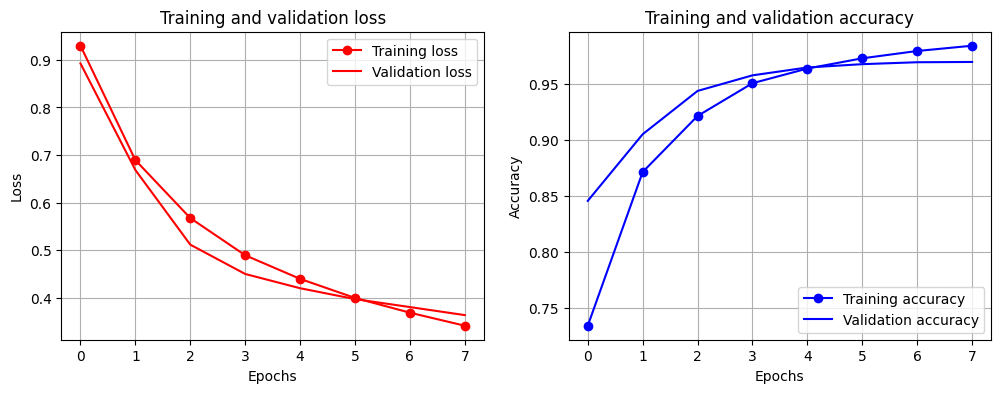

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3804
           1       0.98      0.96      0.97      4314

    accuracy                           0.97      8118
   macro avg       0.97      0.97      0.97      8118
weighted avg       0.97      0.97      0.97      8118


Confusion Matrix:


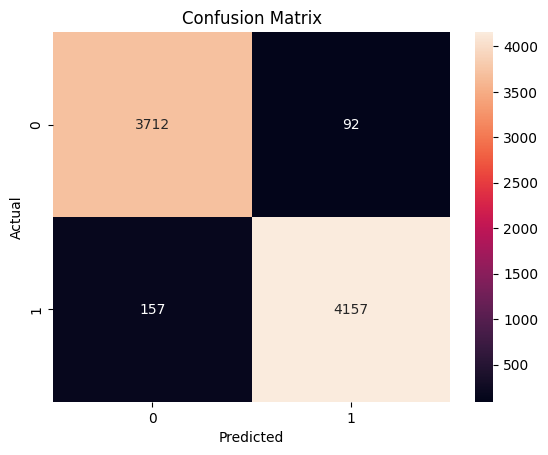

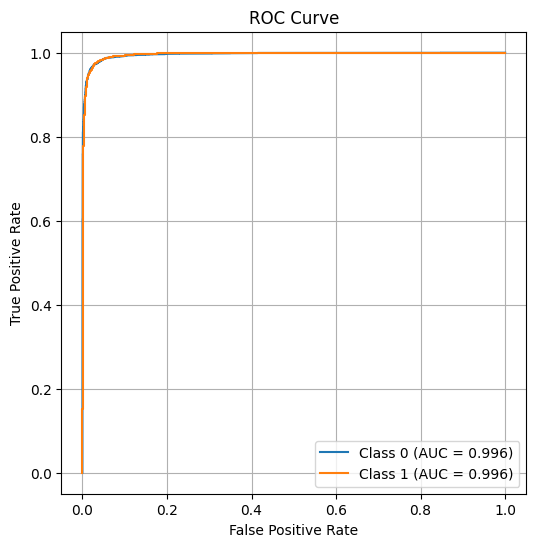

In [18]:
# Vizualizace průběhu trénování
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], "ro-", label="Training loss")
plt.plot(history.history["val_loss"], "r-", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], "bo-", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "b-", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.show()

# Predikce na testovacích datech
y_pred = model.predict(list(X_test_texts.values()))
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Klasifikační report a matice záměn
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_classes, y_pred_classes)

sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC křivka a AUC skóre
plt.figure(figsize=(6, 6))
for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [19]:
# Predikce na testovacích datech
y_pred_probs = model.predict(list(X_test_texts.values()))  # Pravděpodobnosti tříd
y_pred = y_pred_probs.argmax(axis=1)  # Převod na nejpravděpodobnější třídu
y_true = y_test.argmax(axis=1)  # Skutečné hodnoty

# Výpočet metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Výpis výsledků
print(f'🔹 Přesnost: {accuracy:.4f}')
print(f'🔹 Precision: {precision:.4f}')
print(f'🔹 Recall: {recall:.4f}')
print(f'🔹 F1-score: {f1:.4f}')


254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
🔹 Přesnost: 0.9693
🔹 Precision: 0.9695
🔹 Recall: 0.9693
🔹 F1-score: 0.9693
